In [8]:
import glob
import os
import logging
import bitstring
import time
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import re 

_log = logging.getLogger(__name__)

def _decode_sensor_info(dfh, meta):
    """
    Helper to decode the sensor list.

    dfh must be a filehandle because we want to be able to say where we stopped
    in file.
    """

    nsensors_total = int(meta['total_num_sensors'])
    nsensors_used = int(meta['sensors_per_cycle'])
    activeSensorList = [{} for i in range(nsensors_used)]
    outlines = []
    sensorInfo = {}
    for i in range(nsensors_total):
        line = dfh.readline().decode('utf-8')
        if line.split(':')[0] != 's':
            raise ValueError('Failed to parse sensor info')
        splitLine = [string.strip() for string in line.split(' ')[1:]
                     if string and not string.isspace()]
        sensorInfo[splitLine[-2]] = splitLine
        if splitLine[0] == 'T':
            activeSensorList[int(splitLine[2])] = {
                'name': splitLine[-2], 'unit': splitLine[-1],
                'bits': splitLine[-3]}
        outlines = outlines + [line]

    bindatafilepos = dfh.tell()  # keep this for seeking

    return activeSensorList, sensorInfo, outlines, bindatafilepos
def _get_cached_sensorlist(cachedir, meta):
    """
    Helper to get the sensor list from a file in the cache
    """
    fname0 = cachedir + '/' + meta['sensor_list_crc'].upper() + '.CAC'
    dd = glob.glob(cachedir + '/*')
    found = False
    for d in dd:
        if (os.path.split(d)[1].upper() ==
                os.path.split(fname0)[1].upper()):
            found = True
            break
    if not found:
        raise FileNotFoundError(f'Could not find {fname0}')

    with open(d, 'rb') as dfh:
        activeSensorList, sensorInfo, outlines, bindatafilepos = \
                _decode_sensor_info(dfh, meta)

    return activeSensorList, sensorInfo

def _make_cache(outlines, cachedir, meta):
    """
    Helper to make a cache file if one doesn't exist.
    """
    try:
        os.mkdir(cachedir)
    except FileExistsError:
        pass

    fname = cachedir + '/' + meta['sensor_list_crc'] + '.CAC'
    with open(fname, 'w') as dfh:
        for line in outlines:
            dfh.write(line)

def dbd_get_meta(filename, cachedir):
    """
    Get metadata from a dinkum binary file.

    Parameters
    ----------

    filename : str
        filename of the dinkum binary file (i.e. *.dbd, *.ebd)

    cachedir : str
        Directory where the cached CAC sensor lists are kept.  These
        lists are often in directories like ``../Main_board/STATE/CACHE/``.
        These should be copied somewhere locally.  Recommend ``./cac/``.

    Returns
    -------
    meta : dict
        Dictionary of the meta data for this dinkum binary file.

    """

    meta = {}

    with open(filename, 'rb') as dfh:
        meta['num_ascii_tags'] = 99  # read the first 99 lines
        while (len(meta) < int(meta['num_ascii_tags'])):
            line = dfh.readline().decode('utf-8')
            meta[line.split(':')[0]] = line.split(':')[1].strip()
        if len(meta) != int(meta['num_ascii_tags']):
            raise ValueError('Did not find expected number of tags')
        bindatafilepos = dfh.tell()
        localcache = False
        # if the sensor data is here, we need to read it, even though we
        # will use the cache
        if ('sensor_list_factored' in meta and
                not int(meta['sensor_list_factored'])):
            localcache = True
            activeSensorList, sensorInfo, outlines, bindatafilepos = \
                _decode_sensor_info(dfh, meta)

        # read the cache first.  If its not there, try to make one....
        try:
            activeSensorList, sensorInfo = \
                _get_cached_sensorlist(cachedir, meta)
        except FileNotFoundError:
            if localcache:
                _log.info('No cache file found; trying to create one')
                _make_cache(outlines, cachedir, meta)
            else:
                raise FileNotFoundError(
                    'No active sensor list found for crc ',
                    f'{meta["sensor_list_crc"]}. These are often found in ',
                    'offloaddir/Science/STATE/CACHE/ or ',
                    'offloaddir/Main_board/STATE/CACHE/. ',
                    f'Copy those locally into {cachedir}')
        meta['activeSensorList'] = activeSensorList
        # get the file's timestamp...
        meta['_dbdfiletimestamp'] = os.path.getmtime(filename)

    return meta, bindatafilepos

def dbd_to_dict(dinkum_file, cachedir, keys=None):
    """
    Translate a dinkum binary file to a dictionary of data and meta values.

    Parameters
    ----------
    dinkum_file : dbd file name (full path)
        These are the raw data from the glider, either offloaded from a card
        or from the dockserver.

    cachedir : str
        Directory where the cached CAC sensor lists are kept.  These
        lists are often in directories like ``../Main_board/STATE/CACHE/``.
        These should be copied somewhere locally.  Recommend ``./cac/``.

    keys : list of str
        list of sensor names to include in the *data* dictionary.  This
        allows us to make the dictionaries more compact and not have
        all the redundant sensor info.  If a single string then keys is a
        file name and passed to  `~.slocum.parse_filter_file` to get the list
        of keys.

    Returns
    -------
    data : dict
        dictionary of all the data with sensor names as keys, filtered
        according to the *keys* kwarg.

    meta : dict
        dictionary of all the meta data in the file.

    """
    # Parse ascii header - read in the metadata.
    data = []
    DINKUMCHUNKSIZE = int(3e4)  # how much data to pre-allocate

    if isinstance(keys, str):
        keys = parse_filter_file(keys)

    meta, bindatafilepos = dbd_get_meta(dinkum_file, cachedir)
    activeSensorList = meta['activeSensorList']
    dfh = open(dinkum_file, 'rb')
    # ------------------------------------------
    # All subsequent lines are in binary format.
    # Grab the seek pos and use that for a bookmark.
    # ------------------------------------------
    # offset for number of characters already read in.
    _log.debug('reading file from %d', bindatafilepos * 8)
    binaryData = bitstring.BitStream(dfh, offset=bindatafilepos * 8)
    # First there's the s,a,2byte int, 4 byte float, 8 byte double.
    # sometimes the endianess seems to get swapped.
    # ref_tuple = ['s', 'a', 4660, 123.456, 123456789.12345]
    diag_header = binaryData.readlist(['bits:8', 'bits:8'])
    diag_header[0] = chr(int(diag_header[0].hex, 16))
    diag_header[1] = chr(int(diag_header[1].hex, 16))
    if not (diag_header[0] == 's') and (diag_header[1] == 'a'):
        _log.warning("character failure: %s != 's', 'a'", diag_header)
        raise ValueError('Diagnostic header check failed.')

    endian = 'be'
    data = binaryData.read(f'uint{endian}:16')
    _log.debug('Checking endianness %s == 4660 or 13330', data)
    if data == 4660:
        pass
    elif data == 13330:
        endian = 'le'
    else:
        _log.warning("integer failure: %s != 4660", data)
        raise ValueError("Diagnostic header check failed.")
    _log.debug('Endianness is %s', endian)

    data = binaryData.read(f'float{endian}:32')
    if not np.allclose(data, 123.456):
        _log.warning("float32 failure: %s != 123.456", data)
        raise ValueError("Diagnostic header check failed.")

    data = binaryData.read(f'float{endian}:64')
    if not np.allclose(data, 123456789.12345):
        _log.warning("float64 failure: %s != 123456789.12345", data)
        raise ValueError("Diagnostic header check failed.")
    _log.debug('Diagnostic check passed.  Endian is %s', endian)

    nsensors = int(meta['sensors_per_cycle'])
    currentValues = np.zeros(int(meta['sensors_per_cycle'])) + np.NaN
    data = np.zeros((DINKUMCHUNKSIZE, nsensors)) + np.NaN
    # Then there's a data cycle with every sensor marked as updated, giving
    # us our initial values.
    # 01 means updated with 'same value', 10 means updated with a new value,
    # 11 is reserved, 00 is not updated.
    # This character leads off each byte cycle.
    frameCheck = binaryData.read('bytes:1').decode("utf-8")
    updatedCode = ['00'] * int(meta['sensors_per_cycle'])

    # Data cycle begins now.
    # Cycle tag is a ascii 'd' character. Then
    # state_bytes_per_cycle * state_bytes (2bits per sensor) of state bytes.
    # Then data for each updated sensor as per the state bytes.
    # Then zeroes until the last byte is completed, should they be necessary.
    _log.info('Parsing binary data')
    proctimestart = time.time()
    ndata = 0
    while frameCheck == 'd':
        for i in range(int(meta['sensors_per_cycle'])):
            updatedCode[i] = binaryData.read('bin:2')
        # burn off any remaining bits to get to the first full bit.
        binaryData.bytealign()
        for i, code in enumerate(updatedCode):
            if code == '00':  # No new value
                currentValues[i] = np.NaN
            elif code == '01':  # Same value as before.
                continue
            elif code == '10':  # New value.
                if int(activeSensorList[i]['bits']) in [4, 8]:
                    currentValues[i] = binaryData.read(
                        f'float{endian}:' +
                        str(int(activeSensorList[i]['bits']) * 8))
                elif int(activeSensorList[i]['bits']) in [1, 2]:
                    currentValues[i] = binaryData.read(
                        f'uint{endian}:' +
                        str(int(activeSensorList[i]['bits']) * 8))
                else:
                    raise ValueError('Bad bits')
            else:
                raise ValueError(('Unrecognizable code in data cycle. ',
                                  'Parsing failed'))
        data[ndata] = currentValues
        binaryData.bytealign()

        # We've arrived at the next line.
        try:
            d = binaryData.peek('bytes:1').decode('utf-8')
        except bitstring.ReadError:
            _log.debug('position at end of stream %d',
                       binaryData.pos + 8 * bindatafilepos)
            _log.warning('End of file reached without termination char')
            d = 'X'
        if d == 'd':
            frameCheck = binaryData.read('bytes:1').decode('utf-8')
            ndata += 1
            if ndata % DINKUMCHUNKSIZE == 0:
                # need to allocate more data!
                data = np.concatenate(
                    (data, np.NaN + np.zeros((DINKUMCHUNKSIZE, nsensors))),
                    axis=0)
        elif d == 'X':
            # End of file cycle tag. We made it through.
            # throw out pre-allocated data we didn't use...
            data = data[:ndata]
            break
        else:
            raise ValueError(f'Parsing failed at {binaryData.bytepos}. ',
                             f'Got {d} expected d or X')

    proctimeend = time.time()
    _log.info(('%s lines of data read from %s, data rate of %s rows '
               'per second') % (len(data), dinkum_file,
                                len(data) / (proctimeend - proctimestart)))
    dfh.close()

    _log.info('Putting data into dictionary')
    ddict = dict()

    # deal 2-D array into a dictionary...  Only keep keys we want...
    for n, key in enumerate(meta['activeSensorList']):
        if keys is None or key['name'] in keys:
            ddict[key['name']] = data[:, n]

    return ddict, meta

# from https://nedbatchelder.com/blog/200712/human_sorting.html
# this is for the alphanum_key at the end of the initial glob data ingest 
###############################################################################
def tryint(s):
    """
    Return an int if possible, or `s` unchanged.
    """
    try:
        return int(s)
    except ValueError:
        return s

def alphanum_key(s):
    """
    Turn a string into a list of string and number chunks.
    >>> alphanum_key("z23a")
    ["z", 23, "a"]
    """
    return [ tryint(c) for c in re.split('([0-9]+)', s) ]

def human_sort(l):
    """
    Sort a list in the way that humans expect.
    """
    l.sort(key=alphanum_key)
###############################################################################

# INITIAL INJEST
sbd_raw  = sorted(glob.glob('../../d_process_glider_files/spectre/*.sbd'),key=alphanum_key)
tbd_raw  = sorted(glob.glob('../../d_process_glider_files/spectre/*.tbd'),key=alphanum_key)

# tbd_raw[0]
final = pd.DataFrame()

loopnum = range(0,len(sbd_raw))

# need to look through ^ files and put into one dataframe 
for i in loopnum:

    sbd_file = sbd_raw[i]
    # tbd_file = tbd_raw[i]

    sbd,sbd_meta = dbd_to_dict(sbd_file,'../../d_process_glider_files/rutgers-cac/')
    # tbd,tbd_meta = dbd_to_dict(tbd_file,'rutgers-cac/')

    # This imports the data into two nice Pandas DataFrame.
    sbd = pd.DataFrame.from_dict(sbd, orient='columns', dtype=None, columns=None).set_index('m_present_time')
    # tbd = pd.DataFrame.from_dict(tbd, orient='columns', dtype=None, columns=None).set_index('sci_m_present_time')

    # This cleans up the DataFrame time indices.
    sbd.index = pd.to_datetime(sbd.index,unit='s').round(freq='S')
    # tbd.index = pd.to_datetime(tbd.index,unit='s').round(freq='S')

    # This combines them into one DataFrame
    data = pd.concat([sbd]).sort_index()

    # append data to the final dataframe
    # this is what combines each file's segmement into one dataframe 
    final = pd.concat([final, data])

End of file reached without termination char
End of file reached without termination char
End of file reached without termination char
End of file reached without termination char
End of file reached without termination char
End of file reached without termination char


In [9]:
def str2num_north_west(lat_str,lon_str):
    """
    Docstring: A brief description of what the function does.

    Parameters:
    - parameter1 (type): Description of parameter1.
    - parameter2 (type): Description of parameter2.
    ...

    Returns:
    type: Description of the return value.
    """
    lat = []
    lon = []

    for i in range(len(lon_str)): 
        
        # latitude strings
        latdegstr = str(lat_str[i])[0:2]    # first 2
        latminstr = str(lat_str[i])[2:]     # everything but first 2

        # latitude strings to integers for mapping 
        latmaploop = (float(latdegstr)) + ((float(latminstr)))/60
        lat.append(latmaploop)

        # longitude strings
        londegstr = str(lon_str[i])[1:3]
        lonminstr = str(lon_str[i])[3:]

        # longitude strings to integers for mapping 
        lonmaploop = (float(londegstr)) + ((float(lonminstr)))/60
        lon.append(-lonmaploop)

    coords = pd.DataFrame()     # put the above into final dataframe
    coords['lat'] = lat
    coords['lon'] = lon
    coords = coords.set_index(lon_str.index)

    # Return statement: If the function returns a value
    return coords

def lmc2deg(x_lmc, lat, lon):
    """
    Convert linear distance in meters (both latitude and longitude) to angular distance in degrees using geopy.

    Parameters:
    - x_lmc: Linear distance in meters for longitude.
    - y_lmc: Linear distance in meters for latitude.
    - lat: Latitude of the location in degrees.
    - lon: Longitude of the location in degrees.

    Returns:
    - lmc_lat: Angular distance in degrees for latitude.
    - lmc_lon: Angular distance in degrees for longitude.
    """
    # Convert linear distances to kilometers
    # lat_km = y_lmc / 1000.0
    lat_km = 0
    lon_km = x_lmc / 1000.0

    # Use geopy to calculate the destination points for both latitude and longitude
    dest_lat = geodesic(kilometers=lat_km).destination(point=(lat, lon), bearing=0)
    dest_lon = geodesic(kilometers=lon_km).destination(point=(lat, lon), bearing=90)

    # Get the latitude and longitude of the destination points
    lmc_lat = dest_lat.latitude
    lmc_lon = dest_lon.longitude

    # Get the latitude and longitude of the destination points
    lmc_lat = dest_lat.latitude
    lmc_latbot = lmc_lat - 5
    lmc_lattop = lmc_lat + 5

    lat = (lmc_latbot,lmc_lattop)
    lon = (lmc_lon,lmc_lon)

    return lat,lon

lat_str = (final['m_lat'].dropna()) 
lon_str = (final['m_lon'].dropna())

coords = str2num_north_west(lat_str,lon_str)

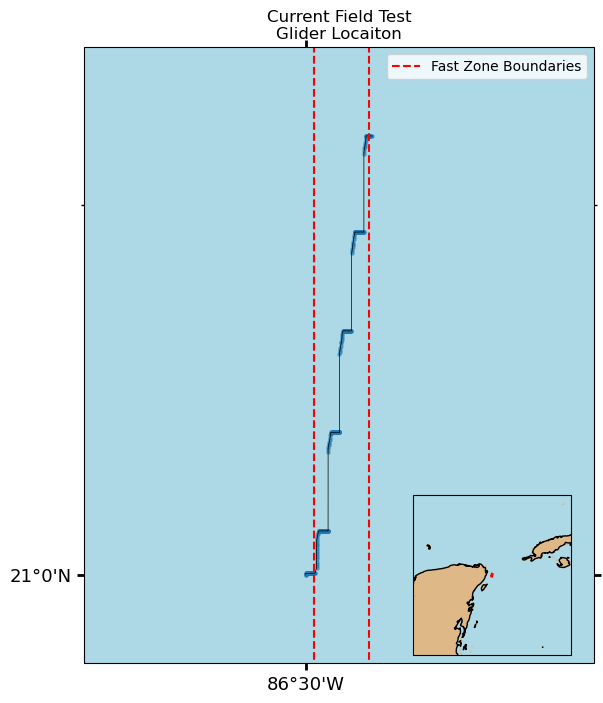

In [16]:
# MAP MAP MAP MAP MAP MAP MAP MAP
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean.cm as cmo
import cartopy.crs as ccrs
import cool_maps.plot as cplt
from geopy.distance import geodesic

# I like these things this way
# plt.rcParams['axes.grid'] = True
# plt.rcParams['lines.linewidth'] = 0.4

# locator_extent = [-75.2, -71.4, 38, 41.3]

# wp_lat = [
#     39+(27.437/60),
#     39+(17.583/60),
#     39+(07.744/60),
#     38+(55.899/60),
#     38+(46.046/60),
# ]

# wp_lon = [
#     -74+(-11.587/60),
#     -73+(-56.607/60),
#     -73+(-39.926/60),
#     -73+(-20.627/60),
#     -73+(-04.705/60),
# ]

# min / max of ^ waypoints with 0.1 buffer 
# extent = [np.min(wp_lon)-0.1,np.max(wp_lon)+0.1,np.min(wp_lat)-0.1,np.max(wp_lat)+0.1]

extent_buff_lon = 0.05
extent_buff_lat = 0.02
big_extent_buff = 4

extent = ([min(coords['lon']) - extent_buff_lon, max(coords['lon']) + extent_buff_lon, min(coords['lat']) - extent_buff_lat, max(coords['lat']) + extent_buff_lat])
big_extent = ([min(coords['lon']) - big_extent_buff, max(coords['lon']) + big_extent_buff, min(coords['lat']) - big_extent_buff, max(coords['lat']) + big_extent_buff])

# Create the main map
fig, ax = cplt.create(extent, proj=ccrs.PlateCarree(), bathymetry=False, figsize=(12, 8), oceancolor=('lightblue'))

# Plot the main data on the main map
plt.scatter(coords['lon'], coords['lat'], marker='.',s=20,alpha=0.5, cmap='cool', transform=ccrs.PlateCarree())
plt.plot(coords['lon'], coords['lat'], linewidth=0.5,color='black', transform=ccrs.PlateCarree())

plt.title('Current Field Test\nGlider Locaiton')

# # Add a colorbar
# sm = plt.cm.ScalarMappable(cmap='cool', norm=plt.Normalize(vmin=coords.index.min().value, vmax=coords.index.max().value))
# sm._A = []
# cbar = plt.colorbar(sm, pad=0)
# cbar.ax.set_yticklabels(pd.to_datetime(cbar.get_ticks()).strftime(date_format='%b %d'))

# plot fast zone
lat1,lon1 = lmc2deg(200, coords['lat'][0], coords['lon'][0])
lat2,lon2 = lmc2deg(1500, coords['lat'][0], coords['lon'][0])
ax.plot(lon1,lat1, marker='o', linestyle='--', color='red', markersize=0.2,label='Fast Zone Boundaries', transform=ccrs.PlateCarree())
ax.plot(lon2,lat2, marker='o', linestyle='--', color='red', markersize=0.2, transform=ccrs.PlateCarree())

# Create the locator map (overview map)
# axes at position [x, y, width, height]
ax_locator = fig.add_axes([0.54, 0.12, 0.2, 0.2], projection=ccrs.PlateCarree())
# plt.plot(wp_lon, wp_lat, marker='o', markersize=3, linewidth=1, color='black', transform=ccrs.PlateCarree())
plt.plot(coords['lon'], coords['lat'], linewidth=2,color='red', transform=ccrs.PlateCarree())

# Set the extent for the locator map (using the initalized earlier didn't work for some reason)
ax_locator.set_extent(big_extent)

# Add features to the locator map (e.g., coastlines)
ax_locator.add_feature(cfeature.COASTLINE, edgecolor='black')
ax_locator.add_feature(cfeature.OCEAN, color='lightblue')
ax_locator.add_feature(cfeature.LAND, color='burlywood') # I liked that color

ax.legend()
plt.show()

Text(0.5, 1.0, 'LMC Coords (bs_cft.mi)')

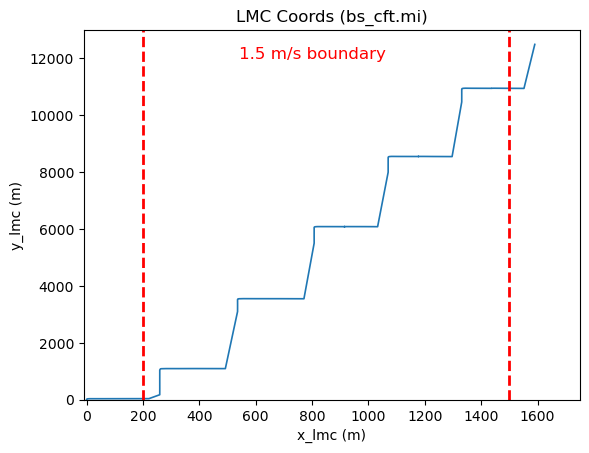

In [5]:
cy_lmc = final['c_wpt_y_lmc'].dropna()
cx_lmc = data['c_wpt_x_lmc'].dropna()

y_lmc = final['m_y_lmc'].dropna()
x_lmc = final['m_x_lmc'].dropna()

# Assuming 'data' is your DataFrame and 'm_heading' is the column you want to convert
heading = np.degrees(data['m_heading'].dropna())

fig,ax = plt.subplots()

ax.plot(x_lmc, y_lmc,linewidth=1.2)
# ax.plot(x_lmc,heading)

# start line
start_curr = 200
ax.axvline(start_curr, color='red', linestyle='--', linewidth=2,label='Static Line')

# end line
end_curr = 1500
ax.axvline(end_curr, color='red', linestyle='--', linewidth=2,label='Static Line')

# label the boundary
ax.text(800,12000, '1.5 m/s boundary', color='red', fontsize=12, horizontalalignment='center')

ax.set_ylim(0,13000)
ax.set_xlim(-10,1750)
ax.set_xlabel('x_lmc (m)')
ax.set_ylabel('y_lmc (m)')
ax.set_title('LMC Coords (bs_cft.mi)')

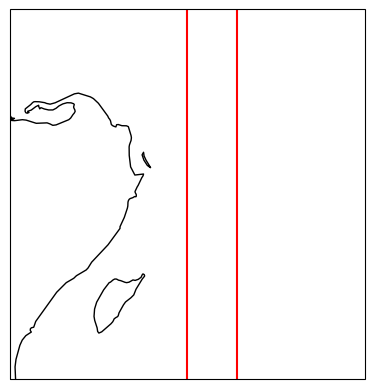

In [21]:
# debug plot 
# plt.plot(coords['lon'],coords['lat'])

# Create a map using PlateCarree projection (latitude and longitude)
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})

# Set the extent of the map based on the trackline data
ax.set_extent([min(coords['lon']) - 1, max(coords['lon']) + 1, min(coords['lat']) - 1, max(coords['lat']) + 1])

# Add coastlines
ax.coastlines()

# Plot the trackline
lat1,lon1 = lmc2deg(500, coords['lat'][0], coords['lon'][0])
lat2,lon2 = lmc2deg(30000, coords['lat'][0], coords['lon'][0])
ax.plot(lon1,lat1, marker='o', linestyle='-', color='red', markersize=0.2, transform=ccrs.PlateCarree())
ax.plot(lon2,lat2, marker='o', linestyle='-', color='red', markersize=0.2, transform=ccrs.PlateCarree())

# Show the map
plt.show()

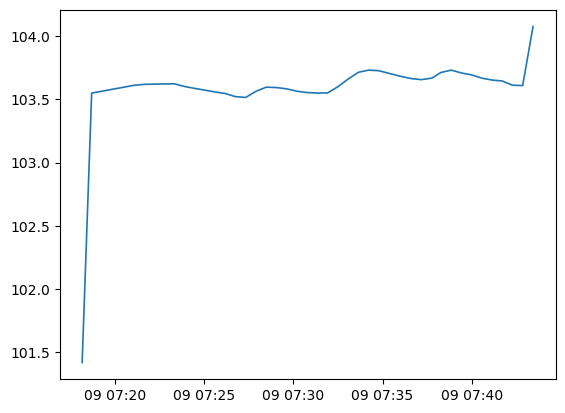

In [22]:
heading = np.degrees(data['c_heading'].dropna())
plt.plot(heading,linewidth=1.2)

# inflect = data['m_tot_num_inflections'].dropna()
# inflect

# fig,ax = plt.subplots()

# ax.plot(x_lmc, heading)

Text(0.5, 1.0, 'yos')

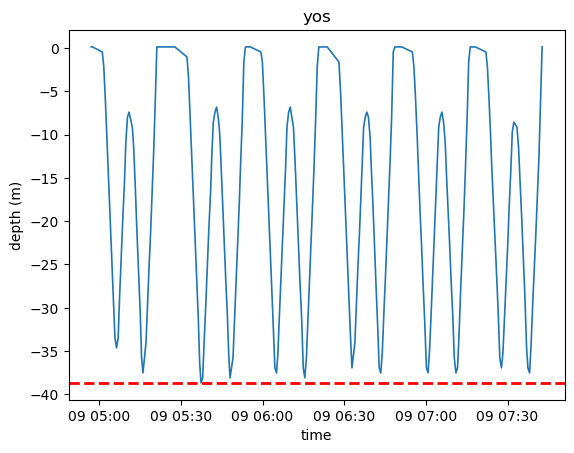

In [23]:
depth = final['m_pressure'].dropna()*-10.1974

fig,ax = plt.subplots()

ax.plot(depth,linewidth=1.2)
# ax.axhline(-30, color='orange', linestyle='--', label='Static Line')
ax.axhline(depth.min(), color='red', linestyle='--', linewidth=2,label='Static Line')
plt.xlabel('time')
plt.ylabel('depth (m)')
plt.title('yos')

# might need again in the future

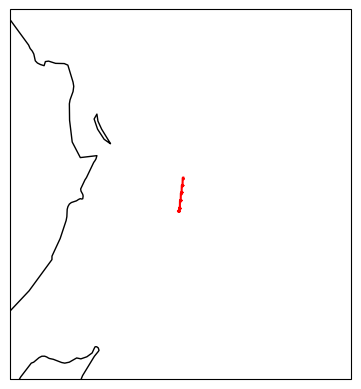

In [12]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# debug plot 
# plt.plot(coords['lon'],coords['lat'])


# Create a map using PlateCarree projection (latitude and longitude)
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})

# Set the extent of the map based on the trackline data
ax.set_extent([min(coords['lon']) - 0.5, max(coords['lon']) + 0.5, min(coords['lat']) - 0.5, max(coords['lat']) + 0.5])

# Add coastlines
ax.coastlines()

# Plot the trackline
ax.plot(coords['lon'], coords['lat'], marker='o', linestyle='-', color='red', markersize=0.2, transform=ccrs.PlateCarree())

# Show the map
plt.show()

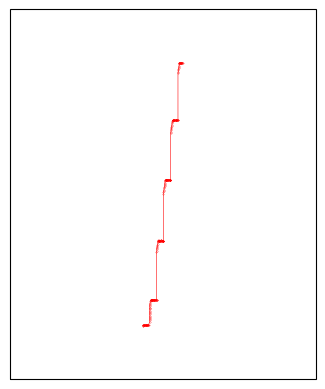

In [18]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# Create a map using PlateCarree projection (latitude and longitude)
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})

# Set the extent of the map based on the trackline data
ax.set_extent([min(coords['lon']) - 0.05, max(coords['lon']) + 0.05, min(coords['lat']) - 0.02, max(coords['lat']) + 0.02])

# Add coastlines
ax.coastlines()

# Plot the trackline
ax.plot(coords['lon'], coords['lat'], marker='o', linestyle='-', color='red', markersize=0.2, transform=ccrs.PlateCarree())

# Show the map
plt.show()

In [ ]:
# from geopy.distance import geodesic

# def lmc2deg(y_lmc, x_lmc, latitude):
#     """
#     Convert linear distance in meters (both latitude and longitude) to angular distance in degrees using geopy.

#     Parameters:
#     - latitude_meters: Linear distance in meters for latitude.
#     - longitude_meters: Linear distance in meters for longitude.
#     - latitude: Latitude of the location in degrees.

#     Returns:
#     - latitude_degrees: Angular distance in degrees for latitude.
#     - longitude_degrees: Angular distance in degrees for longitude.
#     """
    
    
#     for i in y_lmc:

#         # Convert linear distances to kilometers
#         lat_km = i / 1000.0
    
#         # Use geopy to calculate the destination points for both latitude and longitude
#         lmc_lat = geodesic(kilometers=lat_km).destination(point=(latitude, 0), bearing=90).longitude


#     for z in x_lmc:
#         lon_km = z / 1000.0
#         lmc_lon = geodesic(kilometers=lon_km).destination(point=(latitude, 0), bearing=0).latitude

#     return lmc_lat,lmc_lon

# lmc_lat,lmc_lon = lmc2deg(x_lmc,y_lmc,coords['lat'][0])

In [ ]:
# lat_str = (final['m_lat'].dropna()) 
# lon_str = (final['m_lon'].dropna())

# need to be strings to easily pick out deg and min
# need to be strings to easily pick out deg and min
# need to be strings to easily pick out deg and min

# make loop variable
# howmanytoloop = final.shape[0]
# loopnum = range(0,howmanytoloop)

# # clean data to proper format
# lat = []
# lon = []
# latmap = []
# lonmap = []

# for i in loopnum : 
    
#     # latitude strings
#     latdegstr = str(lat_str[i])[0:2]    # first 2
#     latminstr = str(lat_str[i])[2:]     # everything but first 2

#     # latitude strings to integers for mapping 
#     latmaploop = int(float(latdegstr)) + ((int(float(latminstr)))/60)
#     lat.append(latmaploop)

#     # longitude strings
#     londegstr = str(lon_str[i])[1:3]
#     lonminstr = str(lon_str[i])[3:]

#     # longitude strings to integers for mapping 
#     lonmaploop = int(float(londegstr)) + ((int(float(lonminstr)))/60)
#     lon.append(lonmaploop)

# coord_list = pd.DataFrame()     # put the above into final dataframe
# coord_list['lat'] = lat
# coord_list['lon'] = lon